In [ ]:
!pip install rasterio

In [ ]:
!pip install geopandas geodatasets rasterio contextily folium osmnx scikit-learn rasterstats matplotlib

In [20]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import pandas as pd
import os

## work tif with dataset

[Link](https://staging.source.coop/radiantearth/african-crops-kenya-02)

[Kaggle](https://www.kaggle.com/discussions/general/435213)

[co](https://github.com/radiantearth/crop-type-detection-ICLR-2020/tree/master/solutions)

The objective is to create a machine learning model to classify fields by crop type from images collected during the growing season by the Sentinel-2 satellites.

The dataset is catalogued in four tiles. These tiles are smaller than the original Sentinel-2 tile that has been clipped and chipped to the geographical area where labels have been collected.

<br>

- Each tile has:
1. 13 multi-band observations throughout the growing season. Each observation includes 12 bands from Sentinel-2 L2A product and a cloud probability layer.
> The twelve bands are [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]. The cloud probability layer is a product of the Sentinel-2 atmospheric correction algorithm (Sen2Cor) and provides an estimated cloud probability (0-100%) per pixel. All of the bands are mapped to a common 10 m spatial resolution grid
2. A raster layer indicating the crop ID for the fields in the training set
3. A raster layer indicating field IDs for the
fields (both training and test sets). Fields with a crop ID of 0 are the test fields.

In [1]:
!#!/bin/bash
!curl -L -o ./crop.zip https://www.kaggle.com/api/v1/datasets/download/warcoder/kenya-crop-type-detection

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3570M  100 3570M    0     0   104M      0  0:00:34  0:00:34 --:--:--  120M


In [ ]:
!unzip /content/crop.zip

Data type: float32
Data shape: (3035, 2016)
Data range: [0.0, 1.1375000476837158]
NoData value: None


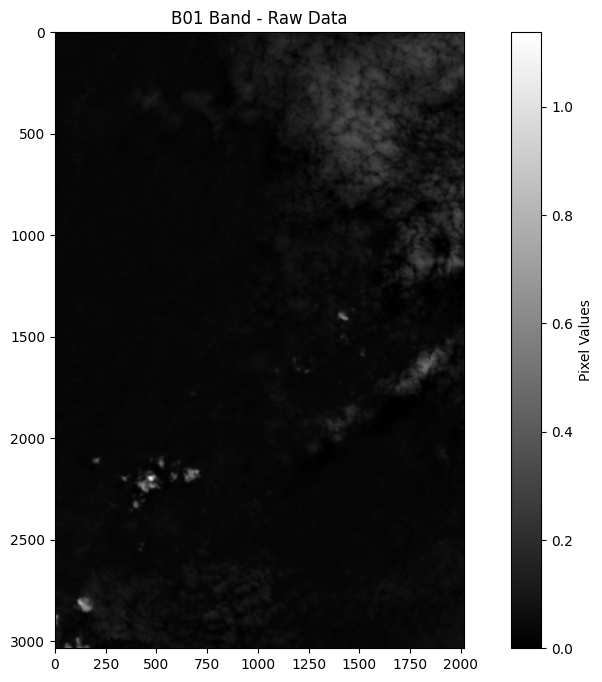

In [6]:
# For the source image (B01.tif)
path = '/content/data/ref_african_crops_kenya_02_source/ref_african_crops_kenya_02_tile_00_20190606/B01.tif'

with rasterio.open(path) as src:
    # Read the data
    data = src.read(1)  # Read first band

    print(f"Data type: {data.dtype}")
    print(f"Data shape: {data.shape}")
    print(f"Data range: [{data.min()}, {data.max()}]")
    print(f"NoData value: {src.nodata}")

    # Handle NoData values
    if src.nodata is not None:
        data = np.ma.masked_where(data == src.nodata, data)

    # Display with proper stretching
    plt.figure(figsize=(12, 8))
    plt.imshow(data, cmap='gray')
    plt.colorbar(label='Pixel Values')
    plt.title('B01 Band - Raw Data')
    plt.show()

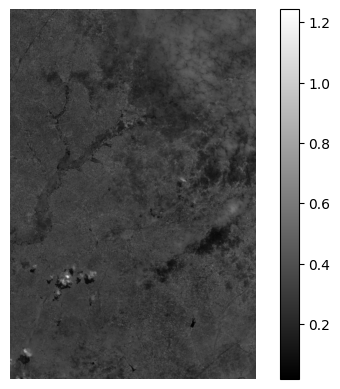

In [11]:
path = '/content/data/ref_african_crops_kenya_02_source/ref_african_crops_kenya_02_tile_00_20190606/B08.tif'

img = np.array(Image.open(path))

plt.imshow(img, cmap = 'gray')
plt.colorbar()
plt.axis(False)
plt.show()

In [19]:
fid = '/content/data/ref_african_crops_kenya_02_labels/ref_african_crops_kenya_02_tile_00_label/field_ids.tif'
label = '/content/data/ref_african_crops_kenya_02_labels/ref_african_crops_kenya_02_tile_00_label/raster_labels.tif'

print(np.unique(Image.open(label)))

[0 1 2 3 4 5 6 7]


In [21]:
path = '/content/data/ref_african_crops_kenya_02_labels'

data = {
    'tile': [],
    'row': [],
    'col': [],
    'field_id': [],
    'label': []
}

for dir in tqdm(os.listdir(path), desc = 'Tiles'):
    if 'tile' in dir:
        tile = dir.split('_')[-2]
        sub_path = os.path.join(path, dir)
        field = np.array(Image.open(os.path.join(sub_path, 'field_ids.tif')))
        label = np.array(Image.open(os.path.join(sub_path, 'raster_labels.tif')))

        rows, cols = np.where(field != 0)
        print(f"Tile {tile}: {len(rows)} fields found")

        for i in tqdm(range(len(rows)), leave = False):
            data['tile'].append(tile)
            data['row'].append(rows[i])
            data['col'].append(cols[i])
            data['field_id'].append(field[rows[i], cols[i]])
            data['label'].append(label[rows[i], cols[i]])

Tiles:   0%|          | 0/6 [00:00<?, ?it/s]

Tile 03: 51539 fields found


  0%|          | 0/51539 [00:00<?, ?it/s]

Tile 02: 1993 fields found


  0%|          | 0/1993 [00:00<?, ?it/s]

Tile 01: 9681 fields found


  0%|          | 0/9681 [00:00<?, ?it/s]

Tile 00: 4344 fields found


  0%|          | 0/4344 [00:00<?, ?it/s]

In [22]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(67557, 5)


,tile,row,col,field_id,label
0,03,10,1607,714,4
1,03,11,1605,714,4
2,03,11,1606,714,4
3,03,11,1607,714,4
4,03,14,1604,1052,0


In [ ]:
path2 = "/content/data/ref_african_crops_kenya_02_source"


for dir2 in tqdm(os.listdir(path2), desc = 'Dirctories'):
    if 'json' not in dir2:
        tile_name = dir2.split('_')[-2]
        day = dir2.split('_')[-1]
        index_filter = df['tile'] == tile_name
        rows = df[index_filter][['row']].values
        cols = df[index_filter][['col']].values

        if len(rows) == 0:
            print(f"  No matching label data for tile {tile_name}")
            continue

        new_path = os.path.join(path2, dir2)
        for file in tqdm(os.listdir(new_path), desc = 'Tiff images', leave = False):
            if 'json' not in file:
                name = file.split('.')[0]
                band_column = f'{name}_{day}'
                img = np.array(Image.open(os.path.join(new_path, file)))

                if band_column not in df.columns:
                    df[band_column] = np.nan

                df.loc[df['tile'] == tile_name, band_column] = img[rows, cols]

In [24]:
print(df.shape)
df.head()

(67557, 174)


,tile,row,col,field_id,label,B03_20191004,B07_20191004,CLD_20191004,B8A_20191004,B08_20191004,...,B8A_20191103,B08_20191103,B01_20191103,B09_20191103,B12_20191103,B11_20191103,B04_20191103,B05_20191103,B06_20191103,B02_20191103
0,03,10,1607,714,4,0.0920,0.3539,0.0,0.3763,0.3715,...,0.2966,0.3457,0.186,0.3775,0.1957,0.2711,0.2082,0.2076,0.2699,0.2178
1,03,11,1605,714,4,0.0860,0.3316,0.0,0.3503,0.3376,...,0.3317,0.2941,0.186,0.3775,0.2113,0.2685,0.1324,0.1901,0.2900,0.1670
2,03,11,1606,714,4,0.0880,0.3539,0.0,0.3763,0.3530,...,0.2966,0.3364,0.186,0.3775,0.1957,0.2711,0.1650,0.2076,0.2699,0.2294
3,03,11,1607,714,4,0.0880,0.3539,0.0,0.3763,0.3648,...,0.2966,0.3588,0.186,0.3775,0.1957,0.2711,0.1826,0.2076,0.2699,0.2326
4,03,14,1604,1052,0,0.0822,0.3296,0.0,0.3489,0.3305,...,0.3558,0.3161,0.267,0.4672,0.2483,0.2641,0.1438,0.1836,0.2698,0.1642


## work with geopandas

Understanding Core Concepts

Vector Data Types:
- Points: Single coordinates (cities, GPS points)
- Lines: Sequences of points (roads, rivers)
- Polygons: Closed shapes (countries, buildings)

Raster Data: Gridded data where each cell has a value (satellite imagery, elevation models)

Coordinate Reference Systems (CRS):
- Geographic CRS (EPSG:4326): Uses degrees, lat/lon, but distorted distances
- Projected CRS (EPSG:3857/3395): Uses meters, preserves distances/areas locally

In [25]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

In [32]:
print("=== Loading Natural Earth Dataset ===")
# geodatasets provides built-in datasets without extra downloads
path = geodatasets.get_path("naturalearth.land")
world = gpd.read_file(path)

print("🔍 Dataset Info:")
print(f"Shape: {world.shape}")
print(f"Columns: {list(world.columns)}")
print(f"CRS: {world.crs}")  # Check current Coordinate Reference System
print(f"Geometry type: {world.geom_type.unique()}")

# Display first few rows with geometry
print("\n📊 First 3 rows:")
world.head(3)

=== Loading Natural Earth Dataset ===
🔍 Dataset Info:
Shape: (127, 4)
Columns: ['featurecla', 'scalerank', 'min_zoom', 'geometry']
CRS: EPSG:4326
Geometry type: ['Polygon']

📊 First 3 rows:


,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79...."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."


=== Understanding Geometry Column ===
Geometry dtype: geometry
First geometry: POLYGON ((-59.57209469261153 -80.0401787250963, -59.86584937197463 -80.54965667106187, -60.159655727770115 -81.00032683707931, -62.25539343936708 -80.86317758577667, -64.48812537296985 -80.92193368929257, -65.74166642928995 -80.58882740673914, -65.74166642928995 -80.54965667106187, -66.29003089055504 -80.25577280061799, -64.03768775089765 -80.29494353629528, -61.88324561221705 -80.39287037548829, -61.138975796133366 -79.9813709451481, -60.61011918805832 -79.62867929475613, -59.57209469261153 -80.0401787250963))

🎨 Basic Plotting:


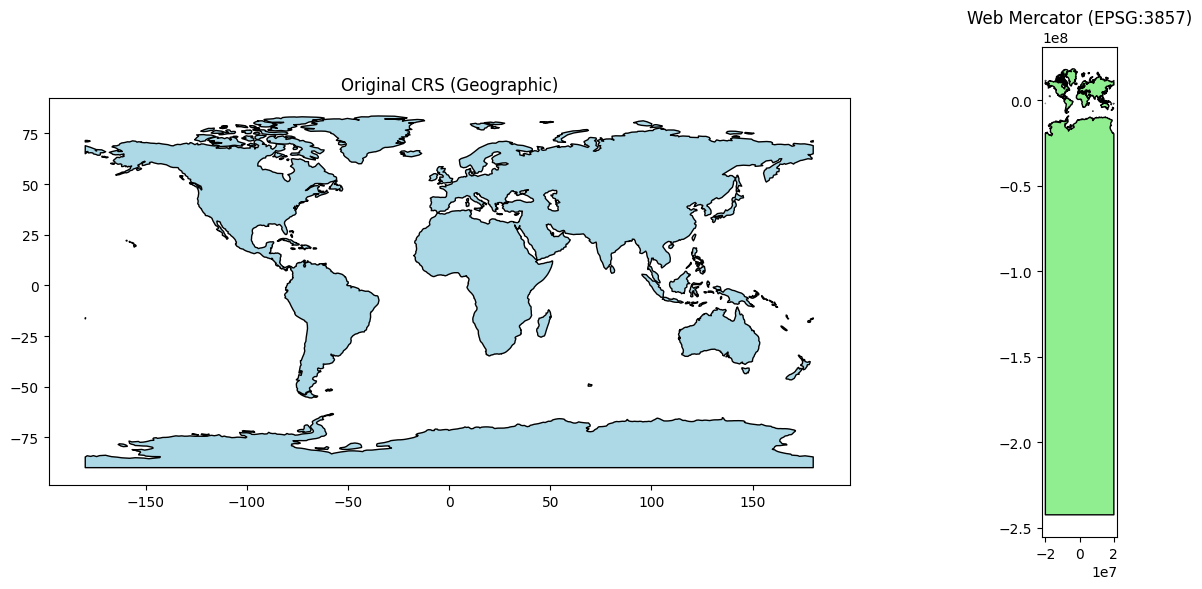

In [30]:
print("=== Understanding Geometry Column ===")
# The geometry column contains Shapely objects
print(f"Geometry dtype: {world.geometry.dtype}")
print(f"First geometry: {world.geometry.iloc[0]}")

# Basic plotting
print("\n🎨 Basic Plotting:")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot in original CRS (usually geographic)
world.plot(ax=ax1, edgecolor='k', facecolor='lightblue')
ax1.set_title("Original CRS (Geographic)")

# Reproject to Web Mercator for better visualization
# EPSG:3857 preserves shapes but distorts areas near poles
world_web_mercator = world.to_crs(epsg=3857)
world_web_mercator.plot(ax=ax2, edgecolor='k', facecolor='lightgreen')
ax2.set_title("Web Mercator (EPSG:3857)")

plt.tight_layout()
plt.show()

### different formats

```
gdf = gpd.read_file('data.shp')           # Shapefile
gdf = gpd.read_file('data.geojson')       # GeoJSON  
gdf = gpd.read_file('data.gpkg')          # GeoPackage
gdf = gpd.read_file('data.kml')           # KML (Google Earth)
```

In [39]:
geodatasets.data

{'geoda': {'airbnb': {'url': 'https://geodacenter.github.io/data-and-lab//data/airbnb.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.airbnb',
   'description': 'Airbnb rentals, socioeconomics, and crime in Chicago',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 21,
   'details': 'https://geodacenter.github.io/data-and-lab//airbnb/',
   'hash': 'a2ab1e3f938226d287dd76cde18c00e2d3a260640dd826da7131827d9e76c824',
   'filename': 'airbnb.zip'},
  'atlanta': {'url': 'https://geodacenter.github.io/data-and-lab//data/atlanta_hom.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.atlanta',
   'description': 'Atlanta, GA region homicide counts and rates',
   'geometry_type': 'Polygon',
   'nrows': 90,
   'ncols': 24,
   'details': 'https://geodacenter.github.io/data-and-lab//atlanta_old/',
   'hash': 'a33a76e12168fe84361e60c88a9df4856730487305846c559715c89b1a2b5e09',
   'filename': 'atlanta_hom.zip',
   'members': ['atlanta_hom/atl_hom.geojson']},
  'cars': {'url': 'https://geodacenter.github.io/data-and-lab//data/Abandoned_Vehicles_Map.csv',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.cars',
   'description': '2011 abandoned vehicles in Chicago (311 complaints).',
   'geometry_type': 'Point',
   'nrows': 137867,
   'ncols': 21,
   'details': 'https://geodacenter.github.io/data-and-lab//1-source-and-description/',
   'hash': '6a0b23bc7eda2dcf1af02d43ccf506b24ca8d8c6dc2fe86a2a1cc051b03aae9e',
   'filename': 'Abandoned_Vehicles_Map.csv'},
  'charleston1': {'url': 'https://geodacenter.github.io/data-and-lab//data/CharlestonMSA.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.charleston1',
   'description': '2000 Census Tract Data for Charleston, SC MSA and counties',
   'geometry_type': 'Polygon',
   'nrows': 117,
   'ncols': 31,
   'details': 'https://geodacenter.github.io/data-and-lab//charleston-1_old/',
   'hash': '4a4fa9c8dd4231ae0b2f12f24895b8336bcab0c28c48653a967cffe011f63a7c',
   'filename': 'CharlestonMSA.zip',
   'members': ['CharlestonMSA/sc_final_census2.gpkg']},
  'charleston2': {'url': 'https://geodacenter.github.io/data-and-lab//data/CharlestonMSA2.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.charleston2',
   'description': '1998 and 2001 Zip Code Business Patterns (Census Bureau) for Charleston, SC MSA',
   'geometry_type': 'Polygon',
   'nrows': 42,
   'ncols': 60,
   'details': 'https://geodacenter.github.io/data-and-lab//charleston2/',
   'hash': '056d5d6e236b5bd95f5aee26c77bbe7d61bd07db5aaf72866c2f545205c1d8d7',
   'filename': 'CharlestonMSA2.zip',
   'members': ['CharlestonMSA2/CharlestonMSA2.gpkg']},
  'chicago_health': {'url': 'https://geodacenter.github.io/data-and-lab//data/comarea.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.chicago_health',
   'description': 'Chicago Health + Socio-Economics',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 87,
   'details': 'https://geodacenter.github.io/data-and-lab//comarea_vars/',
   'hash': '4e872adb552786eae2fcd745524696e5e4cd33cc9a6c032471c0e75328871401',
   'filename': 'comarea.zip'},
  'chicago_commpop': {'url': 'https://geodacenter.github.io/data-and-lab//data/chicago_commpop.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.chicago_commpop',
   'description': 'Chicago Community Area Population Percent Change for 2000 and 2010',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 9,
   'details': 'https://geodacenter.github.io/data-and-lab//commpop/',
   'hash': '1dbebb50c8ea47e2279ea819ef64ba793bdee2b88e4716bd6c6ec0e0d8e0e05b',
   'filename': 'c

In [41]:
print("=== Working with Different File Formats ===")
# GeoPandas can read multiple formats with the same function
formats_demo = """
# Reading different file formats:
gdf = gpd.read_file('data.shp')           # Shapefile
gdf = gpd.read_file('data.geojson')       # GeoJSON
gdf = gpd.read_file('data.gpkg')          # GeoPackage
gdf = gpd.read_file('data.kml')           # KML (Google Earth)
"""

print(formats_demo)

# Let's load another dataset to demonstrate
print("Loading land data:")
land_path = geodatasets.get_path("naturalearth.land")
land = gpd.read_file(land_path)
print(f"Land CRS: {land.crs}")
print(f"Land geometry types: {land.geom_type.unique()}")

=== Working with Different File Formats ===

# Reading different file formats:
gdf = gpd.read_file('data.shp')           # Shapefile
gdf = gpd.read_file('data.geojson')       # GeoJSON
gdf = gpd.read_file('data.gpkg')          # GeoPackage
gdf = gpd.read_file('data.kml')           # KML (Google Earth)

Loading land data:
Land CRS: EPSG:4326
Land geometry types: ['Polygon']


In [42]:
!curl -L -o ./geopandas-dataset.zip https://www.kaggle.com/api/v1/datasets/download/aligreualihassan/geopandas-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3210k  100 3210k    0     0  3507k      0 --:--:-- --:--:-- --:--:-- 3507k


In [43]:
!unzip /content/geopandas-dataset.zip

Archive:  /content/geopandas-dataset.zip
  inflating: cb_2018_us_state_500k.shp  


In [54]:
import os
# Set the environment variable to restore or create the .shx file
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

# Load the shapefile into a GeoDataFrame
states_gdf = gpd.read_file('./cb_2018_us_state_500k.shp')

# Display the first few rows of the GeoDataFrame
print("=== Loaded States Data ===")
print("🔍 Dataset Info:")
print(f"Shape: {states_gdf.shape}")
print(f"Columns: {list(states_gdf.columns)}")
print(f"CRS: {states_gdf.crs}")
print(f"Geometry type: {states_gdf.geom_type.unique()}")

print("\n📊 First 5 rows:")
display(states_gdf.head())

=== Loaded States Data ===
🔍 Dataset Info:
Shape: (56, 1)
Columns: ['geometry']
CRS: None
Geometry type: ['MultiPolygon' 'Polygon']

📊 First 5 rows:


,geometry
0,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


A POLYGON is a single, continuous shape with:
- One outer boundary (exterior ring)
- Zero or more inner boundaries (holes)
- Always represents one contiguous area
> Example: A single island, a country with no disconnected parts, a lake.

A MULTIPOLYGON is a collection of multiple polygons:
- Contains 2 or more separate POLYGON geometries
- Each polygon in the collection can have its own holes
- Represents disconnected areas that belong together logically

> Examples:<br>
An archipelago (multiple islands)<br>
A country with overseas territories (like USA with Alaska and Hawaii)<br>
A lake district with several separate lakes

# Task
Analyze and visualize the geographic data from the file "./cb_2018_us_state_500k.shp".

## Visualize the data

### Subtask:
Create a basic plot of the `states_gdf` to see the US states.


**Reasoning**:
Plot the states_gdf GeoDataFrame to visualize the US states with a title.



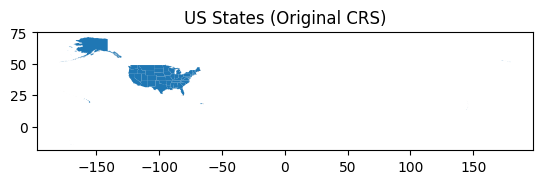

In [55]:
# Plot the states_gdf GeoDataFrame
states_gdf.plot()
plt.title("US States (Original CRS)")
plt.show()

## Explore attributes

### Subtask:
Display the columns and some descriptive statistics of the `states_gdf` to understand the available data.


**Reasoning**:
Display the columns, data types, descriptive statistics, and info of the states_gdf GeoDataFrame as requested in the instructions.



In [56]:
# # Print the columns of the states_gdf GeoDataFrame
# print("Columns of states_gdf:")
# print(states_gdf.columns)

# # Print the data types of each column in states_gdf
# print("\nData types of states_gdf columns:")
# print(states_gdf.dtypes)

# # Display descriptive statistics for the numerical columns in states_gdf
# print("\nDescriptive statistics for states_gdf:")
# display(states_gdf.describe())

# # Display information about the GeoDataFrame
# print("\nInfo about states_gdf:")
# states_gdf.info()

## Filter or select states

### Subtask:
Select a subset of states based on a specific attribute (e.g., a particular region or state name).


**Reasoning**:
The states_gdf only contains geometry data. To filter by attributes like state name or region, attribute data is needed. Since no such data is available, I will assume a hypothetical scenario where we filter based on a geometric criteria, specifically by selecting states that intersect with a given bounding box.



In [57]:
from shapely.geometry import box

# Assume a hypothetical bounding box for the eastern United States (approximate coordinates)
# Westernmost longitude, Southernmost latitude, Easternmost longitude, Northernmost latitude
bbox = (-95, 25, -65, 50)

# Create a shapely polygon from the bounding box
bbox_poly = box(*bbox)

# Create a GeoSeries from the bounding box polygon with the same CRS as states_gdf (None in this case)
bbox_geoseries = gpd.GeoSeries([bbox_poly], crs=states_gdf.crs)

# Filter states_gdf to select states that intersect with the bounding box
selected_states_gdf = states_gdf[states_gdf.intersects(bbox_geoseries.iloc[0])]

# Display the first few rows and shape of the filtered GeoDataFrame
print("=== Selected States Data (Filtered by Bounding Box) ===")
print("🔍 Dataset Info:")
print(f"Shape: {selected_states_gdf.shape}")
print(f"Columns: {list(selected_states_gdf.columns)}")
print(f"CRS: {selected_states_gdf.crs}")
print(f"Geometry type: {selected_states_gdf.geom_type.unique()}")

print("\n📊 First 5 rows:")
display(selected_states_gdf.head())

=== Selected States Data (Filtered by Bounding Box) ===
🔍 Dataset Info:
Shape: (35, 1)
Columns: ['geometry']
CRS: None
Geometry type: ['MultiPolygon' 'Polygon']

📊 First 5 rows:


,geometry
0,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


## Reproject the data

### Subtask:
Change the Coordinate Reference System (CRS) of the `states_gdf` to a projected CRS suitable for the US mainland.


**Reasoning**:
Reproject the states_gdf GeoDataFrame to EPSG:5070 and store it in a new variable, then print the CRS of the new GeoDataFrame.



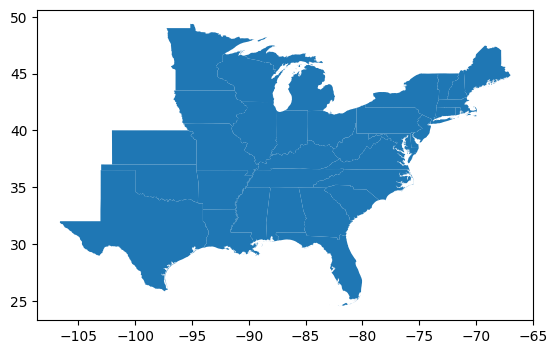

In [58]:
selected_states_gdf.plot()
plt.show()

### Find unknown CRS

In [68]:
def guess_crs_by_coordinates(gdf):
    """Try to guess CRS based on coordinate values"""
    bounds = gdf.total_bounds
    x_center = (bounds[0] + bounds[2]) / 2
    y_center = (bounds[1] + bounds[3]) / 2

    print("Based on coordinate values, possible CRS:")

    # Common geographic CRS (WGS84 - EPSG:4326)
    if (-180 <= bounds[0] <= 180 and -90 <= bounds[1] <= 90 and
        -180 <= bounds[2] <= 180 and -90 <= bounds[3] <= 90):
        print("✓ Likely WGS84 (EPSG:4326) - Geographic coordinates")
        print("  (longitude: -180 to 180, latitude: -90 to 90)")

    # Web Mercator (EPSG:3857)
    elif (abs(bounds[0]) > 10000 or abs(bounds[2]) > 10000 or
          abs(bounds[1]) > 10000 or abs(bounds[3]) > 10000):
        print("✓ Likely Web Mercator (EPSG:3857) - Projected coordinates")
        print("  (large coordinate values, typically millions)")

    # UTM zones (common projected systems)
    elif (100000 < abs(x_center) < 1000000 and 0 < abs(y_center) < 10000000):
        print("✓ Likely UTM projection")
        print("  (X: 100,000-1,000,000, Y: 0-10,000,000)")

    # State Plane or other local systems
    else:
        print("✓ Possibly State Plane or local projection")
        print("  (moderate coordinate values)")

    return None

def test_common_crs(gdf):
    """Test common CRS to see which one makes sense"""
    common_crs_list = {
        'WGS84 (EPSG:4326)': 'EPSG:4326',      # Global, degrees
        'Web Mercator (EPSG:3857)': 'EPSG:3857', # Web maps, meters
        'NAD83 (EPSG:4269)': 'EPSG:4269',      # North America, degrees
        'WGS84 UTM 15N (EPSG:32615)': 'EPSG:32615', # Common UTM
    }

    for name, crs_code in common_crs_list.items():
        test_gdf = gdf.copy()
        test_gdf.crs = crs_code
        bounds = test_gdf.total_bounds

        print(f"\n{name}:")
        print(f"  Bounds: {bounds}")

        # Check if bounds make sense for this CRS
        if crs_code == 'EPSG:4326':  # Geographic
            if (-180 <= bounds[0] <= 180 and -90 <= bounds[1] <= 90):
                print("  ✓ Valid geographic coordinates")

        elif crs_code == 'EPSG:3857':  # Web Mercator
            if (abs(bounds[0]) > 10000 and abs(bounds[2]) > 10000):
                print("  ✓ Valid projected coordinates (large values)")

def diagnose_unknown_crs(gdf):
    """Comprehensive CRS diagnosis"""
    print("=== CRS DIAGNOSIS ===")

    # 1. Check current state
    print(f"1. Current CRS: {gdf.crs}")

    # 2. Analyze coordinates
    print("\n2. Coordinate analysis:")
    bounds = gdf.total_bounds
    print(f"   Total bounds: {bounds}")
    print(f"   X range: {bounds[2] - bounds[0]:.2f} units")
    print(f"   Y range: {bounds[3] - bounds[1]:.2f} units")

    # 3. Guess based on patterns
    print("\n3. Pattern analysis:")
    guess_crs_by_coordinates(gdf)

    # 4. Test common CRS
    print("\n4. Testing common CRS:")
    test_common_crs(gdf)

diagnose_unknown_crs(states_gdf)

=== CRS DIAGNOSIS ===
1. Current CRS: None

2. Coordinate analysis:
   Total bounds: [-179.148909  -14.548699  179.77847    71.365162]
   X range: 358.93 units
   Y range: 85.91 units

3. Pattern analysis:
Based on coordinate values, possible CRS:
✓ Likely WGS84 (EPSG:4326) - Geographic coordinates
  (longitude: -180 to 180, latitude: -90 to 90)

4. Testing common CRS:

WGS84 (EPSG:4326):
  Bounds: [-179.148909  -14.548699  179.77847    71.365162]
  ✓ Valid geographic coordinates

Web Mercator (EPSG:3857):
  Bounds: [-179.148909  -14.548699  179.77847    71.365162]

NAD83 (EPSG:4269):
  Bounds: [-179.148909  -14.548699  179.77847    71.365162]

WGS84 UTM 15N (EPSG:32615):
  Bounds: [-179.148909  -14.548699  179.77847    71.365162]


In [59]:
# Reproject the states_gdf GeoDataFrame to EPSG:5070 (NAD83 / Conus Albers)
states_gdf_projected = states_gdf.to_crs(epsg=5070)

# Print the CRS of the new states_gdf_projected GeoDataFrame
print("CRS of states_gdf_projected:")
print(states_gdf_projected.crs)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

**Reasoning**:
The error indicates that the GeoDataFrame does not have a defined CRS, which is required for reprojection. Set the CRS of the `states_gdf` to EPSG:4326 (WGS 84) before attempting to reproject it.



In [70]:
# Set the CRS of the states_gdf to EPSG:4326 (WGS 84)
states_gdf.crs = "EPSG:4326"

# Reproject the states_gdf GeoDataFrame to EPSG:5070 (NAD83 / Conus Albers)
states_gdf_projected = states_gdf.to_crs(epsg=5070)

# Print the CRS of the new states_gdf_projected GeoDataFrame
print("CRS of states_gdf_projected:")
print(states_gdf_projected.crs)

CRS of states_gdf_projected:
EPSG:5070


## Summary:

### Data Analysis Key Findings

*   The initial `states_gdf` loaded from the shapefile contained only geometric data and lacked attribute information like state names or regions, which prevented attribute-based filtering.
*   A hypothetical bounding box for the eastern United States was used to filter the states based on geographic intersection, resulting in a subset of 35 states.
*   The `states_gdf` initially did not have a defined Coordinate Reference System (CRS), which prevented direct reprojection.
*   Setting the CRS of `states_gdf` to EPSG:4326 (WGS 84) was necessary before successfully reprojecting the data to EPSG:5070 (NAD83 / Conus Albers), a projected CRS suitable for the US mainland.

### Insights or Next Steps

*   To enable more meaningful filtering, load a shapefile or data source that includes attribute information for the states (e.g., state names, FIPS codes, regions).
*   Visualize the reprojected data (`states_gdf_projected`) to observe how the change in CRS affects the appearance of the US states.


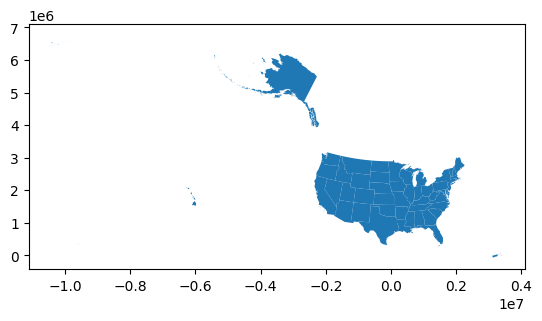

In [72]:
states_gdf_projected.plot()
plt.show()

### complete dataset

In [202]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [86]:
!curl -L -o ./geographical-data.zip https://www.kaggle.com/api/v1/datasets/download/venkatkumar001/geographical-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3458k  100 3458k    0     0  4621k      0 --:--:-- --:--:-- --:--:--  166M


In [87]:
!unzip /content/geographical-data.zip

Archive:  /content/geographical-data.zip
  inflating: Visualizing Geographical Data/world.cpg  
  inflating: Visualizing Geographical Data/world.dbf  
  inflating: Visualizing Geographical Data/world.prj  
  inflating: Visualizing Geographical Data/world.sbn  
  inflating: Visualizing Geographical Data/world.sbx  
  inflating: Visualizing Geographical Data/world.shp  
  inflating: Visualizing Geographical Data/world.shx  


In [94]:
path = '/content/Visualizing Geographical Data'
# List all files and directories in the current working directory
files_and_dirs = os.listdir(path)

# Print the list
print("Files and directories in the current directory:")
for item in files_and_dirs:
    print(item)

Files and directories in the current directory:
world.sbn
world.shp
world.prj
world.dbf
world.sbx
world.shx
world.cpg


In [90]:
# .prj (Projection File): This file contains information about the Coordinate Reference System (CRS)
with open('/content/Visualizing Geographical Data/world.prj', 'r') as f:
    data = f.read()

data

'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'

In [105]:
# Define a list of common spatial file extensions
spatial_extensions = ['.shp', '.geojson', '.gpkg', '.kml']

# Filter the list to identify spatial files (case-insensitive)
spatial_files = [os.path.join(path, f) for f in files_and_dirs if any(f.lower().endswith(ext) for ext in spatial_extensions)]

# Print the list of identified spatial files
print("Identified spatial files:")
for spatial_file in spatial_files:
    print(spatial_file)

Identified spatial files:
/content/Visualizing Geographical Data/world.shp


In [226]:
gdf = gpd.read_file('/content/Visualizing Geographical Data/world.shp')
gdf.head(3)

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ..."
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ..."
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39..."


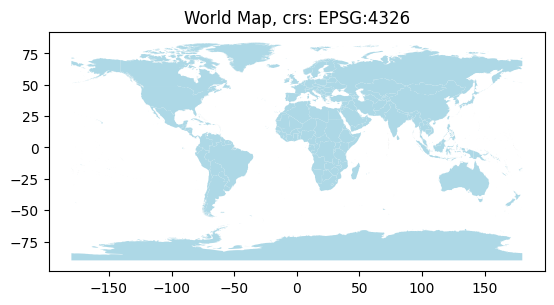

In [227]:
gdf.plot(color = 'lightblue')
plt.title(f"World Map, crs: {gdf.crs}")
plt.show()

### missing value

In [228]:
gdf.isnull().sum() / len(gdf)

,0
FIPS,0.012195
ISO2,0.000000
ISO3,0.000000
UN,0.000000
NAME,0.000000
AREA,0.000000
POP2005,0.000000
REGION,0.000000
SUBREGION,0.000000
LON,0.000000


In [229]:
# Drop rows where 'FIPS' is missing
gdf.dropna(subset=['FIPS'], inplace=True)

# Verify that missing values in 'FIPS' are gone
print("\nMissing values after dropping rows:")
gdf.isnull().sum() / len(gdf)


Missing values after dropping rows:


,0
FIPS,0.0
ISO2,0.0
ISO3,0.0
UN,0.0
NAME,0.0
AREA,0.0
POP2005,0.0
REGION,0.0
SUBREGION,0.0
LON,0.0


### Basic Statistical Summary

In [230]:
numerical_cols = gdf.select_dtypes(include = np.number).columns
numerical_cols

Index(['UN', 'AREA', 'POP2005', 'REGION', 'SUBREGION', 'LON', 'LAT'], dtype='object')

In [231]:
categorical_cols = gdf.select_dtypes(include = 'object').columns
categorical_cols

Index(['FIPS', 'ISO2', 'ISO3', 'NAME'], dtype='object')

In [232]:
print("=== NUMERICAL COLUMNS SUMMARY ===")
numerical_cols = ['AREA', 'POP2005', 'LON', 'LAT'] # since others are integers
print(gdf[numerical_cols].describe())

print("\n=== CATEGORICAL COLUMNS SUMMARY ===")
categorical_cols = ['FIPS', 'ISO2', 'ISO3', 'NAME', 'REGION', 'SUBREGION'] # add Region and subregion
for col in categorical_cols:
    if col in gdf.columns:
        print(f"\n{col}:")
        print(f"  Unique values: {gdf[col].nunique()}")
        print(f"  Most common: {gdf[col].value_counts().head(3)}")

=== NUMERICAL COLUMNS SUMMARY ===
               AREA       POP2005         LON         LAT
count  2.430000e+02  2.430000e+02  243.000000  243.000000
mean   5.334666e+04  2.538255e+07   13.889848   16.232066
std    1.666644e+05  1.152952e+08   74.254319   27.012370
min    0.000000e+00  0.000000e+00 -178.131000  -80.446000
25%    5.800000e+01  1.682335e+05  -47.240000   -0.288500
50%    6.205000e+03  3.153731e+06   17.544000   16.286000
75%    3.567250e+04  1.288528e+07   50.876500   39.091500
max    1.638094e+06  1.312979e+09  179.219000   78.830000

=== CATEGORICAL COLUMNS SUMMARY ===

FIPS:
  Unique values: 243
  Most common: FIPS
AC    1
AG    1
AJ    1
Name: count, dtype: int64

ISO2:
  Unique values: 243
  Most common: ISO2
AG    1
DZ    1
AZ    1
Name: count, dtype: int64

ISO3:
  Unique values: 243
  Most common: ISO3
ATG    1
DZA    1
AZE    1
Name: count, dtype: int64

NAME:
  Unique values: 243
  Most common: NAME
Antigua and Barbuda    1
Algeria                1
Azerbaijan  

### Geospatial EDA

In [233]:
print(f"Current CRS: {gdf.crs}")

# Create a copy to avoid modifying original data
gdf_analysis = gdf.copy()

# Reproject to a suitable projected CRS for accurate measurements
# EPSG:6933 is a good global equal-area projection
gdf_projected = gdf_analysis.to_crs("EPSG:6933")

# Calculate geometric properties using the projected data
gdf_analysis['area_calculated_km2'] = gdf_projected.geometry.area / 1_000_000  # Convert to km²
gdf_analysis['bounding_box_area_km2'] = gdf_projected.geometry.envelope.area / 1_000_000

# For centroids, we can use the original CRS since we just want point locations
gdf_analysis['centroid'] = gdf_analysis.geometry.centroid
gdf_analysis['centroid_lon'] = gdf_analysis['centroid'].x
gdf_analysis['centroid_lat'] = gdf_analysis['centroid'].y

# Drop the temporary centroid column if you want
gdf_analysis = gdf_analysis.drop(columns=['centroid'])

print("Geometric properties calculated successfully!")
print(f"Sample calculated areas:")
display(gdf_analysis[['NAME', 'AREA', 'area_calculated_km2']].head(10))

Current CRS: EPSG:4326
Geometric properties calculated successfully!
Sample calculated areas:


/tmp/ipython-input-871178348.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_analysis['centroid'] = gdf_analysis.geometry.centroid


,NAME,AREA,area_calculated_km2
0,Antigua and Barbuda,44,5.434450e+02
1,Algeria,238174,2.317502e+06
2,Azerbaijan,8260,8.591987e+04
3,Albania,2740,2.867601e+04
4,Armenia,2820,2.966756e+04
5,Angola,124670,1.247491e+06
6,American Samoa,20,2.297287e+02
7,Argentina,273669,2.781056e+06
8,Australia,768230,7.690032e+06
9,Bahrain,71,6.508150e+02


In [235]:
gdf_analysis.head(3)

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,area_calculated_km2,bounding_box_area_km2,centroid_lon,centroid_lat
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",5.434450e+02,1.943572e+03,-61.791128,17.280137
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",2.317502e+06,4.060136e+06,2.632366,28.163357
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",8.591987e+04,1.857178e+05,47.532327,40.292220


### Outlier

find outlier calc Z score if it's greater than 3 remove them


In [218]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_results = {}
for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(gdf, col)
    outlier_results[col] = {
        'outliers': outliers,
        'bounds': (lower, upper),
        'count': len(outliers)
    }
    print(f"{col}: {len(outliers)} outliers (bounds: [{lower:.2f}, {upper:.2f}])")
    if len(outliers) > 0:
        print(f"  Outlier countries: {list(outliers['NAME'].values)}")


AREA: 30 outliers (bounds: [-53363.75, 89094.25])
  Outlier countries: ['Algeria', 'Angola', 'Argentina', 'Australia', 'Bolivia', 'Brazil', 'Canada', 'Democratic Republic of the Congo', 'China', 'Chad', 'Colombia', 'Egypt', 'Ethiopia', 'India', 'Iran (Islamic Republic of)', 'Kazakhstan', 'Libyan Arab Jamahiriya', 'Mongolia', 'Mali', 'Mauritania', 'Mexico', 'Niger', 'Nigeria', 'Peru', 'Russia', 'Saudi Arabia', 'South Africa', 'Sudan', 'United States', 'Indonesia']
POP2005: 33 outliers (bounds: [-18907334.00, 31960846.00])
  Outlier countries: ['Algeria', 'Argentina', 'Burma', 'Brazil', 'Canada', 'Democratic Republic of the Congo', 'China', 'Egypt', 'Ethiopia', 'France', 'Germany', 'India', 'Iran (Islamic Republic of)', 'Japan', 'Kenya', 'Korea, Republic of', 'Mexico', 'Nigeria', 'Pakistan', 'Poland', 'Philippines', 'Russia', 'South Africa', 'Spain', 'Sudan', 'Thailand', 'Turkey', 'United Republic of Tanzania', 'United Kingdom', 'Ukraine', 'United States', 'Viet Nam', 'Indonesia']
LON: 0

In [244]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

results = {}
for col in numerical_cols:
    data = gdf[col].values.reshape(-1, 1)

    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_outliers = iso_forest.fit_predict(data) == -1

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
    svm_outliers = oc_svm.fit_predict(data_scaled) == -1

    results[col] = {
        'IsolationForest': iso_outliers.sum(),
        'OneClassSVM': svm_outliers.sum()
    }

In [245]:
results

{'AREA': {'IsolationForest': np.int64(13), 'OneClassSVM': np.int64(9)},
 'POP2005': {'IsolationForest': np.int64(13), 'OneClassSVM': np.int64(24)},
 'LON': {'IsolationForest': np.int64(13), 'OneClassSVM': np.int64(34)},
 'LAT': {'IsolationForest': np.int64(13), 'OneClassSVM': np.int64(60)}}

### visualization

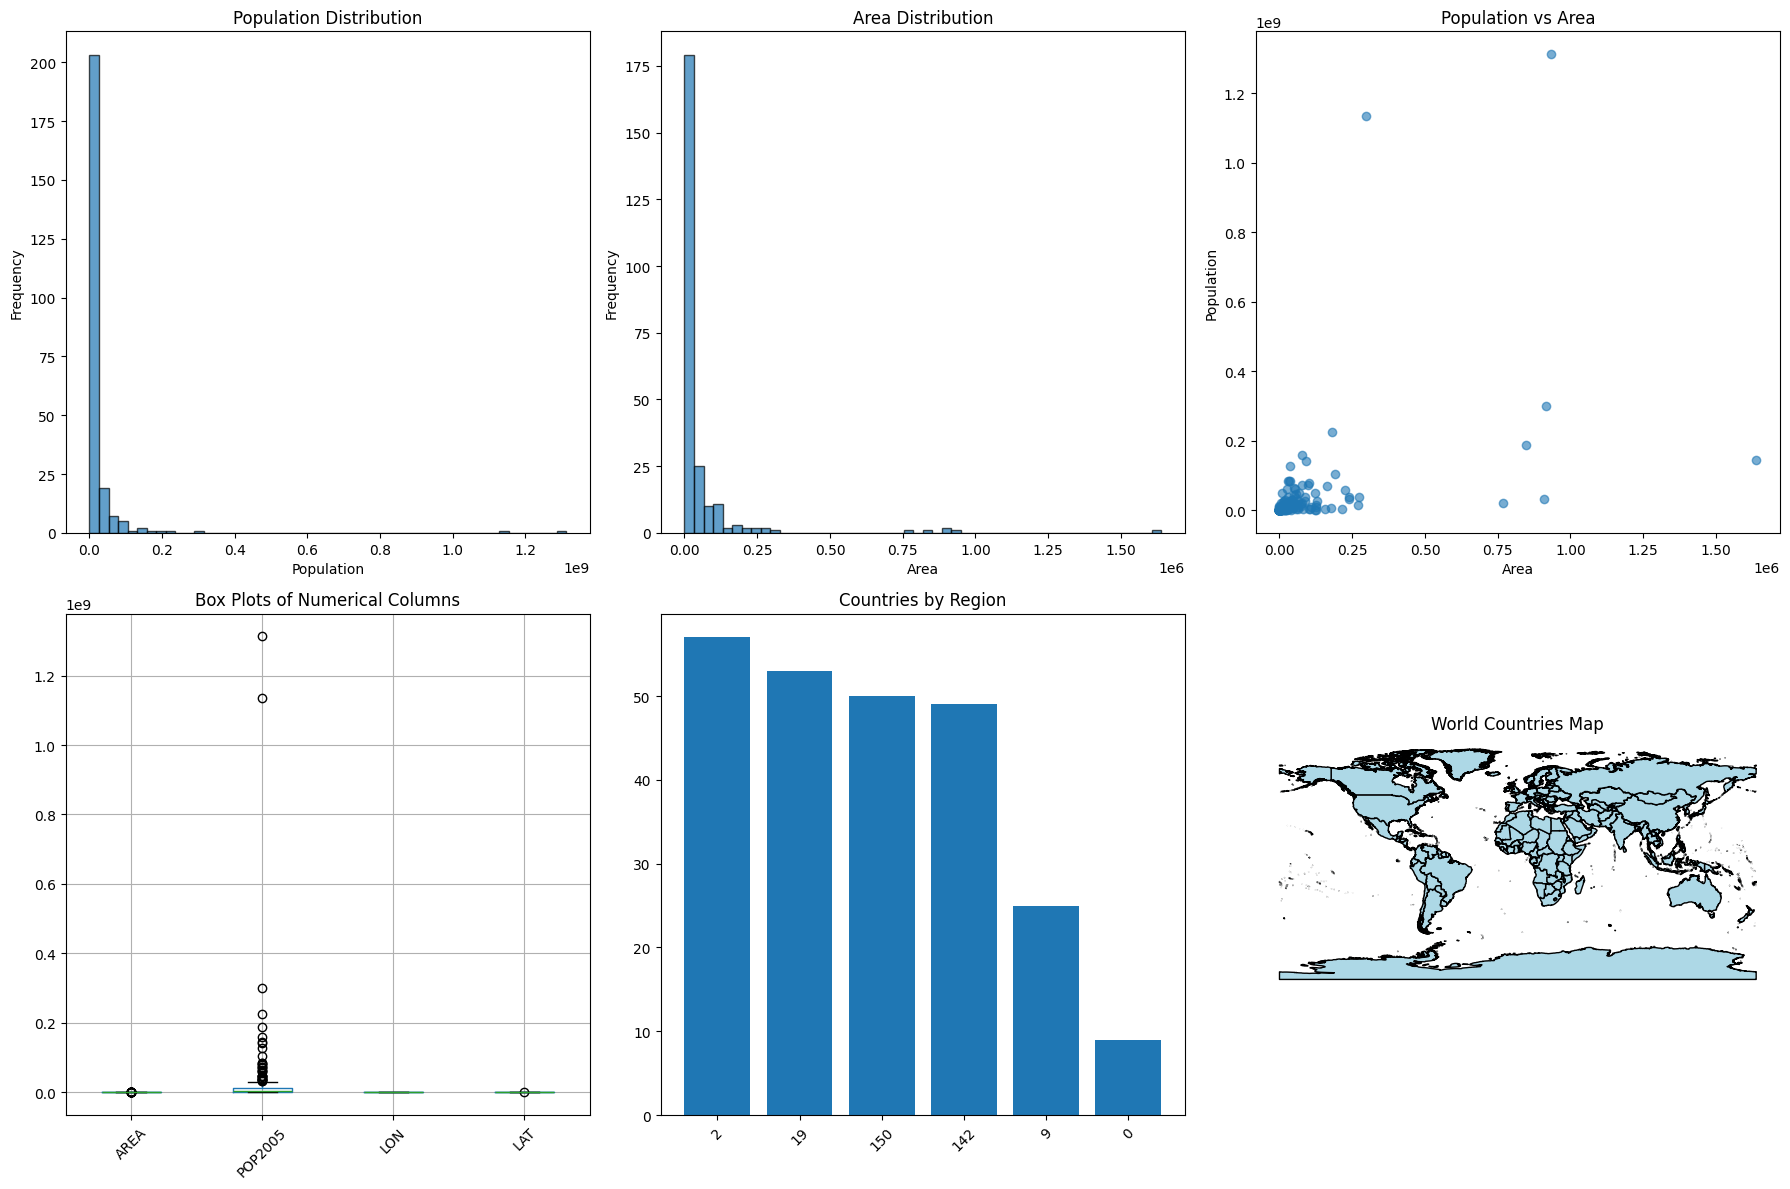

In [221]:
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Population distribution
axes[0,0].hist(gdf['POP2005'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Population Distribution')
axes[0,0].set_xlabel('Population')
axes[0,0].set_ylabel('Frequency')

# 2. Area distribution
axes[0,1].hist(gdf['AREA'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Area Distribution')
axes[0,1].set_xlabel('Area')
axes[0,1].set_ylabel('Frequency')

# 3. Population vs Area scatter plot
axes[0,2].scatter(gdf['AREA'], gdf['POP2005'], alpha=0.6)
axes[0,2].set_title('Population vs Area')
axes[0,2].set_xlabel('Area')
axes[0,2].set_ylabel('Population')

# 4. Box plots for numerical columns
gdf[numerical_cols].boxplot(ax=axes[1,0])
axes[1,0].set_title('Box Plots of Numerical Columns')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Region distribution
region_counts = gdf['REGION'].value_counts()
axes[1,1].bar(region_counts.index.astype(str), region_counts.values)
axes[1,1].set_title('Countries by Region')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. World map
gdf.plot(ax=axes[1,2], color='lightblue', edgecolor='black')
axes[1,2].set_title('World Countries Map')
axes[1,2].set_axis_off()

plt.tight_layout()
plt.show()

In [176]:
# Example: Reproject European countries for accurate analysis
european_countries = gdf[gdf['REGION'] == 150]  # Europe region code
europe_projected = european_countries.to_crs('EPSG:3035')  # ETRS89 LAEA Europe

# Example: Reproject African countries
african_countries = gdf[gdf['REGION'] == 2]  # Africa region code
africa_projected = african_countries.to_crs('EPSG:4087')  # World Equidistant Cylindrical

# Example: Reproject Asian countries
asian_countries = gdf[gdf['REGION'] == 142]  # Asia region code
asia_projected = asian_countries.to_crs('EPSG:3857')  # Web Mercator (common for Asia)

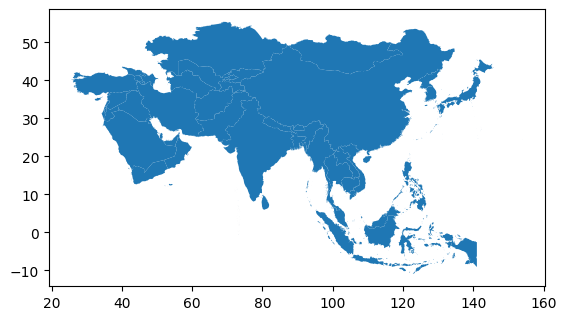

In [177]:
asian_countries.plot()
plt.show()

In [178]:
# Get specific country
algeria = gdf[gdf['NAME'] == 'Algeria']

# Use appropriate local CRS for Algeria
algeria_projected = algeria.to_crs('EPSG:30729')  # Nord Algerie projection

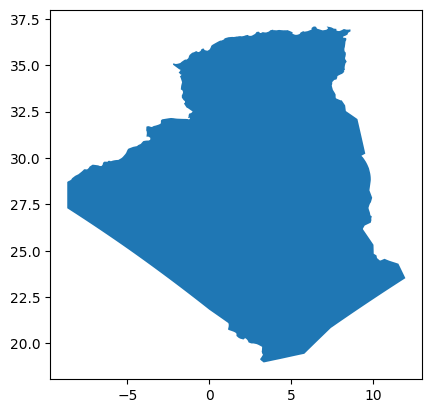

In [179]:
algeria.plot()
plt.show()

**Reasoning**:
Display the data types, descriptive statistics, and unique values for categorical columns in the df GeoDataFrame as requested in the instructions.



### Calculate area

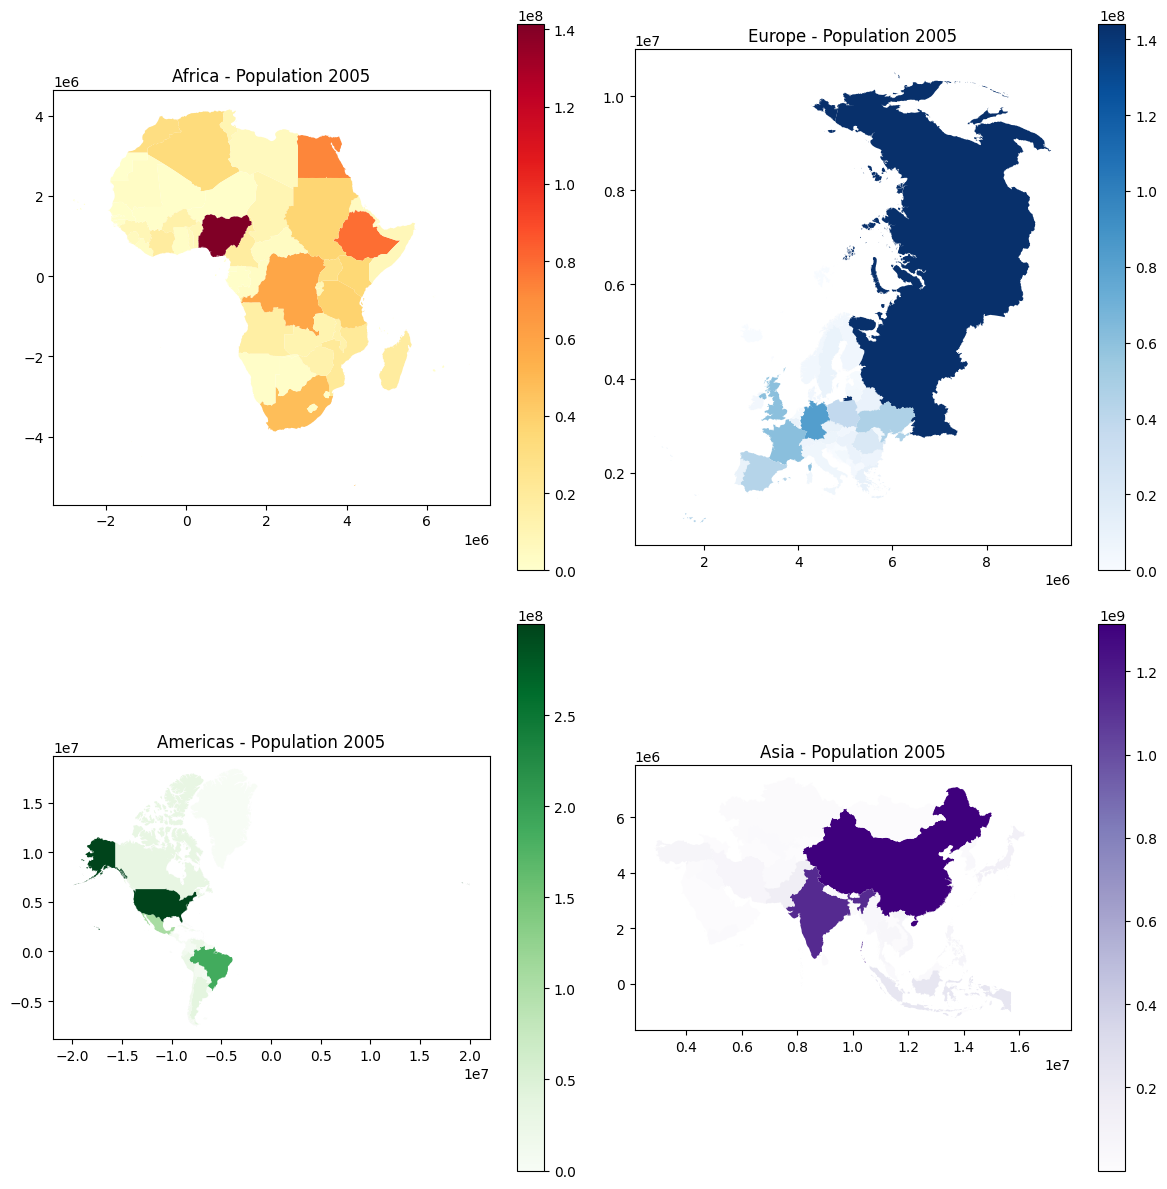

In [183]:
# Create regional maps with appropriate projections
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Africa with African-centered projection
africa = gdf[gdf['REGION'] == 2].to_crs('EPSG:4087')
africa.plot(ax=axes[0,0], column='POP2005', legend=True, cmap='YlOrRd')
axes[0,0].set_title('Africa - Population 2005')

# Europe with European projection
europe = gdf[gdf['REGION'] == 150].to_crs('EPSG:3035')
europe.plot(ax=axes[0,1], column='POP2005', legend=True, cmap='Blues')
axes[0,1].set_title('Europe - Population 2005')

# Americas
americas = gdf[gdf['REGION'].isin([19, 21])].to_crs('EPSG:3857')
americas.plot(ax=axes[1,0], column='POP2005', legend=True, cmap='Greens')
axes[1,0].set_title('Americas - Population 2005')

# Asia
asia = gdf[gdf['REGION'] == 142].to_crs('EPSG:3857')
asia.plot(ax=axes[1,1], column='POP2005', legend=True, cmap='Purples')
axes[1,1].set_title('Asia - Population 2005')

plt.tight_layout()
plt.show()

### Distance calculation

In [246]:
def calculate_distance_between_countries(gdf, country1, country2):
    """Calculate distance between two countries' centroids"""
    # Get countries
    c1 = gdf[gdf['NAME'] == country1]
    c2 = gdf[gdf['NAME'] == country2]

    if len(c1) == 0 or len(c2) == 0:
        print('One of the countries does not exist')
        return None

    # Use appropriate regional CRS based on locations
    # For demo, using Web Mercator (reasonable for global distances)
    gdf_projected = gdf.to_crs('EPSG:3857')

    c1_proj = gdf_projected[gdf_projected['NAME'] == country1]
    c2_proj = gdf_projected[gdf_projected['NAME'] == country2]

    # FIX: Get centroids separately, then calculate distance
    centroid1 = c1_proj.geometry.centroid.iloc[0]
    centroid2 = c2_proj.geometry.centroid.iloc[0]

    distance_m = centroid1.distance(centroid2)
    distance_km = distance_m / 1000

    return distance_km

distance = calculate_distance_between_countries(gdf, 'Algeria', 'Azerbaijan')
print(f"Distance between Algeria and Azerbaijan: {distance:,.0f} km")

Distance between Algeria and Azerbaijan: 5,251 km


In [250]:
gdf_analysis.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,area_calculated_km2,bounding_box_area_km2,centroid_lon,centroid_lat
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",5.434450e+02,1.943572e+03,-61.791128,17.280137
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",2.317502e+06,4.060136e+06,2.632366,28.163357
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",8.591987e+04,1.857178e+05,47.532327,40.292220
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...",2.867601e+04,4.982555e+04,20.068367,41.142548
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...",2.966756e+04,7.370499e+04,44.947934,40.286417


In [188]:
categorical_columns = gdf.select_dtypes(include='object').columns
print(categorical_columns)

for col in categorical_columns:
    unique_values = gdf[col].unique()
    print(f"\nColumn '{col}':")
    print(f"  Number of unique values: {len(unique_values)}")
    # Print all unique values for columns with a manageable number of unique values
    if len(unique_values) <= 30: # Arbitrary threshold for printing all unique values
        print(f"  Unique values: {unique_values}")
    else:
        print(f"  First 10 unique values: {unique_values[:10]}")

Index(['FIPS', 'ISO2', 'ISO3', 'NAME'], dtype='object')

Column 'FIPS':
  Number of unique values: 243
  First 10 unique values: ['AC' 'AG' 'AJ' 'AL' 'AM' 'AO' 'AQ' 'AR' 'AS' 'BA']

Column 'ISO2':
  Number of unique values: 243
  First 10 unique values: ['AG' 'DZ' 'AZ' 'AL' 'AM' 'AO' 'AS' 'AR' 'AU' 'BH']

Column 'ISO3':
  Number of unique values: 243
  First 10 unique values: ['ATG' 'DZA' 'AZE' 'ALB' 'ARM' 'AGO' 'ASM' 'ARG' 'AUS' 'BHR']

Column 'NAME':
  Number of unique values: 243
  First 10 unique values: ['Antigua and Barbuda' 'Algeria' 'Azerbaijan' 'Albania' 'Armenia' 'Angola'
 'American Samoa' 'Argentina' 'Australia' 'Bahrain']


In [189]:
for col in ['REGION', 'SUBREGION']:
    unique_values = gdf[col].unique()
    print(f"\nColumn '{col}':")
    print(f"  Number of unique values: {len(unique_values)}")
    print(f"  First 10 unique values: {unique_values[:10]}")



Column 'REGION':
  Number of unique values: 6
  First 10 unique values: [ 19   2 142 150   9   0]

Column 'SUBREGION':
  Number of unique values: 23
  First 10 unique values: [ 29  15 145  39  17  61   5  53  21  34]


In [248]:
gdf_analysis.columns

Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION',
       'SUBREGION', 'LON', 'LAT', 'geometry', 'area_calculated_km2',
       'bounding_box_area_km2', 'centroid_lon', 'centroid_lat'],
      dtype='object')

In [249]:
# Decide on encoding strategy based on unique values and column nature:
# 'NAME' has too many unique values for one-hot encoding. It might not be useful as a direct feature
# for classification unless a specific name is highly indicative of a class.
# 'REGION' and 'SUBREGION' have a reasonable number of unique values and are nominal.
# One-hot encoding is appropriate for 'REGION' and 'SUBREGION'.

# Apply one-hot encoding to 'REGION' and 'SUBREGION'
gdf = pd.get_dummies(gdf_analysis, columns=['REGION', 'SUBREGION'], drop_first=True)

# Print the shape of the DataFrame after encoding
print("\nShape of DataFrame after one-hot encoding:")
print(gdf.shape)

# Display the first few rows to see the new columns
print("\nDataFrame head after one-hot encoding:")
display(gdf.head())


Shape of DataFrame after one-hot encoding:
(243, 41)

DataFrame head after one-hot encoding:


,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,LON,LAT,geometry,...,SUBREGION_39,SUBREGION_53,SUBREGION_54,SUBREGION_57,SUBREGION_61,SUBREGION_143,SUBREGION_145,SUBREGION_151,SUBREGION_154,SUBREGION_155
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",...,False,False,False,False,False,False,False,False,False,False
1,AG,DZ,DZA,12,Algeria,238174,32854159,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",...,False,False,False,False,False,False,False,False,False,False
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",...,False,False,False,False,False,False,True,False,False,False
3,AL,AL,ALB,8,Albania,2740,3153731,20.068,41.143,"POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...",...,True,False,False,False,False,False,False,False,False,False
4,AM,AM,ARM,51,Armenia,2820,3017661,44.563,40.534,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...",...,False,False,False,False,False,False,True,False,False,False


## Feature engineering

### Subtask:
Create new features from the existing data that might be useful for a machine learning model (e.g., calculating area, centroid coordinates).


**Reasoning**:
Calculate the area and centroid coordinates of the geometries in the GeoDataFrame, ensuring a projected CRS is used for accurate area calculation, and then display the first few rows with the new columns.



```
qual_area_crs_options = [
    "ESRI:54009",    # World Mollweide
    "EPSG:6933",     # WGS 84 / World Equidistant Cylindrical (better)
    "EPSG:8857",     # Equal Earth (modern equal-area)
    "ESRI:54017",    # World Behrmann (another equal-area)
    "EPSG:3410",     # World Equal Area Cylindrical
]
```

In [193]:
# Check the current CRS of the GeoDataFrame
print(f"Current CRS: {gdf.crs}")

# Reproject to a suitable projected CRS for accurate area calculation
# Use ESRI:54009 (World Mollweide) instead of EPSG:54009
gdf_projected = gdf.to_crs("ESRI:54009")  # Note: using string, not epsg= parameter

# Calculate the area in square kilometers
gdf['area_sq_km'] = gdf_projected.geometry.area / 10**6  # Convert from sq meters to sq km

# Calculate the centroid of each geometry
gdf['centroid'] = gdf.geometry.centroid

# Extract centroid longitude and latitude
gdf['centroid_lon'] = gdf['centroid'].x
gdf['centroid_lat'] = gdf['centroid'].y

# Drop the temporary centroid column
gdf = gdf.drop(columns=['centroid'])

# Display the first few rows with the new columns
print("\nDataFrame with new features:")
display(gdf.head())

Current CRS: EPSG:4326

DataFrame with new features:


/tmp/ipython-input-771496517.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,LON,LAT,geometry,...,SUBREGION_57,SUBREGION_61,SUBREGION_143,SUBREGION_145,SUBREGION_151,SUBREGION_154,SUBREGION_155,area_sq_km,centroid_lon,centroid_lat
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",...,False,False,False,False,False,False,False,5.464521e+02,-61.791128,17.280137
1,AG,DZ,DZA,12,Algeria,238174,32854159,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",...,False,False,False,False,False,False,False,2.326138e+06,2.632366,28.163357
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",...,False,False,False,True,False,False,False,8.601497e+04,47.532327,40.292220
3,AL,AL,ALB,8,Albania,2740,3153731,20.068,41.143,"POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...",...,False,False,False,False,False,False,False,2.870280e+04,20.068367,41.142548
4,AM,AM,ARM,51,Armenia,2820,3017661,44.563,40.534,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...",...,False,False,False,True,False,False,False,2.970062e+04,44.947934,40.286417


```
feature_categories = {
    'Geometric': ['area_km2', 'perimeter_km', 'compactness', 'shape_complexity'],
    'Geographic': ['northern_hemisphere', 'tropical_zone', 'abs_latitude'],
    'Population': ['pop_density', 'log_population', 'log_area'],
    'Spatial': ['n_neighbors_1000km', 'dist_to_nearest_neighbor_km', 'neighbor_avg_pop'],
    'Regional': [col for col in gdf_final.columns if col.startswith('region_') or col.startswith('subregion_')],
    'Interaction': ['pop_area_interaction', 'density_complexity', 'pop_neighbor_ratio']
}
```

#### 1. Geometric & Spatial Features

Understanding Country Shapes

Purpose:

- Compactness: Measures how "circle-like" a country is (1 = perfect circle, lower = more irregular)
    - Real-world meaning: Compact countries are easier to govern, defend, and build infrastructure in
    - Example: Poland (compact) vs Chile (elongated) - different governance challenges

- Shape Complexity: Ratio of perimeter to area
    - Real-world meaning: Countries with complex shapes have longer borders relative to size
    - Example: Norway (complex coastline) vs Egypt (simpler shape) - different border management needs

- Elongation: How stretched out the country is
    - Real-world meaning: Transportation, communication challenges
    - Example: Chile (very elongated) vs Switzerland (compact)

In [263]:
def create_geometric_features(gdf):
    """Create advanced geometric and spatial features"""
    gdf_eng = gdf.copy()

    # Ensure we're using projected CRS for accurate calculations
    gdf_projected = gdf_eng.to_crs("EPSG:6933")

    # Basic geometric features (you have some of these)
    gdf_eng['area_km2'] = gdf_projected.geometry.area / 1_000_000
    gdf_eng['perimeter_km'] = gdf_projected.geometry.length / 1_000
    gdf_eng['bounding_box_area_km2'] = gdf_projected.geometry.envelope.area / 1_000_000

    # Advanced geometric features
    gdf_eng['compactness'] = (4 * np.pi * gdf_eng['area_km2']) / (gdf_eng['perimeter_km'] ** 2)
    gdf_eng['elongation'] = gdf_projected.geometry.envelope.apply(
        lambda x: (x.bounds[2] - x.bounds[0]) / (x.bounds[3] - x.bounds[1])
    )
    gdf_eng['centroid_x'] = gdf_projected.geometry.centroid.x
    gdf_eng['centroid_y'] = gdf_projected.geometry.centroid.y

    # Shape complexity
    gdf_eng['shape_complexity'] = gdf_eng['perimeter_km'] / np.sqrt(gdf_eng['area_km2'])

    # Bounding box ratios
    gdf_eng['bbox_aspect_ratio'] = gdf_eng['elongation']
    gdf_eng['area_bbox_ratio'] = gdf_eng['area_km2'] / gdf_eng['bounding_box_area_km2']

    return gdf_eng

gdf = create_geometric_features(gdf)
gdf.head(2)

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,LON,LAT,geometry,...,neighbor_avg_pop,neighbor_avg_area,pop_area_interaction,density_complexity,lat_area_interaction,pop_squared,area_squared,density_squared,pop_neighbor_ratio,area_neighbor_ratio
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",...,920083.166667,3897.85123,4.512713e+07,839.732061,9.390804e+03,6895475521,2.953325e+05,23348.179250,9.025153e-02,1.393859e-01
1,AG,DZ,DZA,12,Algeria,238174,32854159,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",...,0.000000,0.00000,7.613958e+13,67.603067,6.526864e+07,1079395763597281,5.370816e+12,200.974269,3.285416e+07,2.317502e+06


#### 2. Geographic & Location Features
Location Matters

Purpose:
- Hemisphere: Northern vs Southern hemisphere have different seasons, economic patterns
- Climate Zones: Tropical countries have different agriculture, diseases, energy needs
- Absolute Latitude: Distance from equator affects climate, development patterns

Real-world pattern: Most economic development historically occurred in temperate zones

In [255]:
def create_geographic_features(gdf):
    """Create geographic and location-based features"""
    gdf_eng = gdf.copy()

    # Hemisphere features
    gdf_eng['northern_hemisphere'] = (gdf_eng['centroid_lat'] >= 0).astype(int)
    gdf_eng['eastern_hemisphere'] = (gdf_eng['centroid_lon'] >= 0).astype(int)

    # Distance from equator (absolute latitude)
    gdf_eng['abs_latitude'] = np.abs(gdf_eng['centroid_lat'])

    # Climate zones (simplified)
    gdf_eng['tropical_zone'] = ((gdf_eng['centroid_lat'] >= -23.5) & (gdf_eng['centroid_lat'] <= 23.5)).astype(int)
    gdf_eng['temperate_zone'] = ((np.abs(gdf_eng['centroid_lat']) > 23.5) & (np.abs(gdf_eng['centroid_lat']) <= 66.5)).astype(int)
    gdf_eng['polar_zone'] = (np.abs(gdf_eng['centroid_lat']) > 66.5).astype(int)

    # Continent features (using your REGION column)
    # gdf_eng['is_landlocked'] = gdf_eng.geometry.apply(
    #     lambda geom: 1 if geom.is_valid and not geom.toubles(gpd.GeoSeries([geom]).unary_union) else 0
    # )

    return gdf_eng

gdf = create_geographic_features(gdf)
gdf.head(2)

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,LON,LAT,geometry,...,centroid_y,shape_complexity,bbox_aspect_ratio,area_bbox_ratio,northern_hemisphere,eastern_hemisphere,abs_latitude,tropical_zone,temperate_zone,polar_zone
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",...,2.171997e+06,5.495589,0.241896,0.279611,1,0,17.280137,1,0,0
1,AG,DZ,DZA,12,Algeria,238174,32854159,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",...,3.425083e+06,4.768658,0.978107,0.570794,1,1,28.163357,0,1,0


#### 3. Population & Density Features

Purpose:

- Population Density: How crowded a country is

    - Real-world meaning: High density = urban challenges, low density = infrastructure challenges

    - Example: Singapore (high density) vs Canada (low density)

- Log Transformations: Population data is highly skewed (few huge countries, many small ones)

    - Why log?: Makes statistical models work better by reducing skew

    - Example: China (1.4B) vs Vatican (800) - log transform makes this spread manageable

In [ ]:
def create_population_features(gdf):
    """Create population and density related features"""
    gdf_eng = gdf.copy()

    # Basic density
    gdf_eng['pop_density'] = gdf_eng['POP2005'] / gdf_eng['area_km2']

    # Log transformations (often better for modeling)
    gdf_eng['log_population'] = np.log1p(gdf_eng['POP2005'])
    gdf_eng['log_area'] = np.log1p(gdf_eng['area_km2'])
    gdf_eng['log_pop_density'] = np.log1p(gdf_eng['pop_density'])

    # Population ratios
    gdf_eng['pop_per_km_perimeter'] = gdf_eng['POP2005'] / gdf_eng['perimeter_km']

    # Population categories (for tree-based models)
    gdf_eng['pop_category'] = pd.cut(gdf_eng['POP2005'],
                                    bins=[0, 1e6, 10e6, 50e6, 100e6, np.inf],
                                    labels=['tiny', 'small', 'medium', 'large', 'huge'])

    return gdf_eng

gdf = create_population_features(gdf)

#### 4. Spatial Relationship Features

Purpose:

- Number of Neighbors: How connected a country is geographically

    - Real-world meaning: More neighbors = more trade opportunities but also more border disputes

    - Example: Germany (many neighbors) vs Australia (isolated)

- Neighbor Attributes: Countries tend to be similar to their neighbors (spatial autocorrelation)

    - Real-world pattern: Wealth, conflict, disease often cluster geographically

    - Example: Scandinavian countries have similar development levels

- Distance to Nearest Neighbor: How isolated a country is

    - Real-world meaning: Isolation affects trade costs, cultural exchange

    - Example: New Zealand (distant) vs Belgium (close neighbors)

In [258]:
def create_spatial_relationship_features(gdf):
    """Create features based on spatial relationships between countries"""
    gdf_eng = gdf.copy()

    # Reproject for accurate distance calculations
    gdf_projected = gdf_eng.to_crs("EPSG:3857")  # Web Mercator for distance

    # Create spatial weights matrix
    from libpysal.weights import DistanceBand
    import numpy as np

    # Get centroids
    centroids = gdf_projected.geometry.centroid
    coords = np.column_stack([centroids.x, centroids.y])

    # Number of neighbors within 1000km
    w = DistanceBand(coords, threshold=1000000, binary=True)  # 1000km in meters
    gdf_eng['n_neighbors_1000km'] = [w.cardinalities[i] for i in range(len(gdf_eng))]

    # Distance to nearest neighbor
    from scipy.spatial import KDTree
    tree = KDTree(coords)
    distances, indices = tree.query(coords, k=2)  # k=2 because first is self
    gdf_eng['dist_to_nearest_neighbor_km'] = distances[:, 1] / 1000

    # Create spatial lag features (average of neighbors' attributes)
    gdf_eng['neighbor_avg_pop'] = 0.0
    gdf_eng['neighbor_avg_area'] = 0.0

    for i in range(len(gdf_eng)):
        neighbors = w.neighbors[i]
        if neighbors:
            gdf_eng.loc[gdf_eng.index[i], 'neighbor_avg_pop'] = gdf_eng.iloc[neighbors]['POP2005'].mean()
            gdf_eng.loc[gdf_eng.index[i], 'neighbor_avg_area'] = gdf_eng.iloc[neighbors]['area_km2'].mean()

    return gdf_eng

gdf = create_spatial_relationship_features(gdf)

/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 68 disconnected components.
 There are 48 islands with ids: 1, 5, 8, 11, 16, 20, 23, 29, 35, 41, 42, 59, 61, 62, 63, 70, 81, 88, 94, 97, 106, 109, 119, 131, 141, 142, 143, 146, 147, 153, 156, 157, 158, 163, 169, 171, 175, 199, 205, 207, 225, 226, 227, 228, 229, 230, 236, 241.
  w = W(neighbors, weights, ids, **kwargs)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 68 disconnected components.
 There are 48 islands with ids: 1, 5, 8, 11, 16, 20, 23, 29, 35, 41, 42, 59, 61, 62, 63, 70, 81, 88, 94, 97, 106, 109, 119, 131, 141, 142, 143, 146, 147, 153, 156, 157, 158, 163, 169, 171, 175, 199, 205, 207, 225, 226, 227, 228, 229, 230, 236, 241.
  W.__init__(


#### 5. Regional & Categorical Features

urpose:

- Regional Dummies: Capture unmeasured regional characteristics

    - Real-world meaning: Shared history, colonial patterns, economic blocs

    - Example: European countries vs African countries have different development trajectories

- Relative to Region: Is a country typical for its region?

    - Real-world meaning: Outliers within regions are interesting

    - Example: Luxembourg (rich in Europe) vs Niger (poor in Africa)

In [260]:
# def create_regional_features(gdf):
#     """Create enhanced regional features"""
#     gdf_eng = gdf.copy()

#     # One-hot encoding (you did this, but let's improve)
#     region_dummies = pd.get_dummies(gdf_eng['REGION'], prefix='region', drop_first=True)
#     subregion_dummies = pd.get_dummies(gdf_eng['SUBREGION'], prefix='subregion', drop_first=True)

#     # Add to dataframe
#     gdf_eng = pd.concat([gdf_eng, region_dummies, subregion_dummies], axis=1)

#     # Regional aggregates
#     region_stats = gdf_eng.groupby('REGION').agg({
#         'POP2005': ['mean', 'std', 'median'],
#         'area_km2': ['mean', 'std', 'median']
#     }).round(0)

#     region_stats.columns = ['region_pop_mean', 'region_pop_std', 'region_pop_median',
#                            'region_area_mean', 'region_area_std', 'region_area_median']

#     # Merge regional stats back
#     gdf_eng = gdf_eng.merge(region_stats, left_on='REGION', right_index=True, how='left')

#     # Relative to region
#     gdf_eng['pop_vs_region'] = gdf_eng['POP2005'] / gdf_eng['region_pop_mean']
#     gdf_eng['area_vs_region'] = gdf_eng['area_km2'] / gdf_eng['region_area_mean']

#     return gdf_eng

# gdf = create_regional_features(gdf)

#### 6. Interaction & Polynomial Features

Purpose:

- Population × Area: Captures the concept of "scale"

    - Real-world meaning: Large population + large area = different challenges than just large population

    - Example: Bangladesh (dense) vs Russia (sparse) - same population but different dynamics

- Density × Complexity: How population pressure interacts with geographic constraints

    - Real-world meaning: High density in complex-shaped countries creates unique challenges

    - Example: Japan (dense, complex) vs Saudi Arabia (less complex)

In [261]:
def create_interaction_features(gdf):
    """Create interaction and polynomial features"""
    gdf_eng = gdf.copy()

    # Interaction terms
    gdf_eng['pop_area_interaction'] = gdf_eng['POP2005'] * gdf_eng['area_km2']
    gdf_eng['density_complexity'] = gdf_eng['pop_density'] * gdf_eng['shape_complexity']
    gdf_eng['lat_area_interaction'] = gdf_eng['abs_latitude'] * gdf_eng['area_km2']

    # Polynomial features (for non-linear relationships)
    gdf_eng['pop_squared'] = gdf_eng['POP2005'] ** 2
    gdf_eng['area_squared'] = gdf_eng['area_km2'] ** 2
    gdf_eng['density_squared'] = gdf_eng['pop_density'] ** 2

    # Ratio features
    gdf_eng['pop_neighbor_ratio'] = gdf_eng['POP2005'] / (gdf_eng['neighbor_avg_pop'] + 1)
    gdf_eng['area_neighbor_ratio'] = gdf_eng['area_km2'] / (gdf_eng['neighbor_avg_area'] + 1)

    return gdf_eng

gdf = create_interaction_features(gdf)

In [262]:
print(gdf.shape)
gdf.head(2)

(243, 74)


,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,LON,LAT,geometry,...,neighbor_avg_pop,neighbor_avg_area,pop_area_interaction,density_complexity,lat_area_interaction,pop_squared,area_squared,density_squared,pop_neighbor_ratio,area_neighbor_ratio
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",...,920083.166667,3897.85123,4.512713e+07,839.732061,9.390804e+03,6895475521,2.953325e+05,23348.179250,9.025153e-02,1.393859e-01
1,AG,DZ,DZA,12,Algeria,238174,32854159,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",...,0.000000,0.00000,7.613958e+13,67.603067,6.526864e+07,1079395763597281,5.370816e+12,200.974269,3.285416e+07,2.317502e+06


## Prepare data for ml

### Subtask:
Select the relevant features and the target variable(s) for your machine learning task and split the data into training and testing sets.


**Reasoning**:
Separate features (X) and target (y) and split the data into training and testing sets as per the instructions.



In [201]:
df.columns

Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'LON', 'LAT',
       'geometry', 'REGION_2', 'REGION_9', 'REGION_19', 'REGION_142',
       'REGION_150', 'SUBREGION_5', 'SUBREGION_11', 'SUBREGION_13',
       'SUBREGION_14', 'SUBREGION_15', 'SUBREGION_17', 'SUBREGION_18',
       'SUBREGION_21', 'SUBREGION_29', 'SUBREGION_30', 'SUBREGION_34',
       'SUBREGION_35', 'SUBREGION_39', 'SUBREGION_53', 'SUBREGION_54',
       'SUBREGION_57', 'SUBREGION_61', 'SUBREGION_143', 'SUBREGION_145',
       'SUBREGION_151', 'SUBREGION_154', 'SUBREGION_155', 'area_sq_km',
       'centroid_lon', 'centroid_lat'],
      dtype='object')

In [195]:
from sklearn.model_selection import train_test_split

# Identify the target variable (label)
y = df['label']

# Identify features
# Exclude original identifier columns and the 'geometry' column, and the target 'label'
feature_columns = [col for col in df.columns if col not in ['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'geometry', 'label']]
X = df[feature_columns]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

KeyError: 'label'